***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-3.2)** 32-D>16-D>8-D (Coarse>Medium>FINE) use skip connections between Secondary Capsules $Concatenate([P_{caps}, S_{coarse}])$ > input for $S_{medium}$ and $Concatenate([P_{caps}, S_{medium}])$ > input for $S_{fine}$
- Without $L_{Cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = 30BFPC1AXW95
• Working Directory = C:\Users\knoor\Downloads\temp\HD-CapsNet\Training_and_Analysis\1_FMNIST
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : py38tf


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "0" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  0
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


# Parameters

In [4]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

# log directory

In [5]:
directory = sysenv.log_dir('2_FMNIST/HD_CapsNet/HD_CapsNet_WO-Lc')

# Import Dataset : FMNIST

In [6]:
dataset = datasets.F_MNIST(version = 'ALL') # importing Fashion MNIST Dataset
# dataset = datasets.F_MNIST(version = 'reduce') # importing Fashion MNIST Dataset

Fashion-MNIST dataset: Training have 60,000 samples and testing have 10,000 samples


## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Model Architecture

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F):
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*margin_loss(y_true_m, y_pred_m)
    ML_f = LW_F*margin_loss(y_true_f, y_pred_f)
    batch_loss = ML_c + ML_m+ ML_f
    return tf.reduce_mean(batch_loss)

## Architecture

In [10]:
def get_compiled_model():
    
    ## Calling the HD-CapsNet Model
    model = models.HD_CapsNet_Mod_3_3(input_shape     = dataset['x_train'].shape[1:], 
                                      input_shape_yc  = dataset['y_train_coarse'].shape[1:],
                                      input_shape_ym  = dataset['y_train_medium'].shape[1:],
                                      input_shape_yf  = dataset['y_train_fine'].shape[1:], 
                                      no_coarse_class = number_of_classes_c, 
                                      no_medium_class = number_of_classes_m, 
                                      no_fine_class   = number_of_classes_f,
                                      PCap_n_dims     = 8, 
                                      SCap_f_dims     = 8, 
                                      SCap_m_dims     = 16, 
                                      SCap_c_dims     = 32)
    
    ## Saving Model Architecture
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)
    
    ## Add Loss for Model
    model.add_loss(CustomLoss(y_true_c            = model.inputs[1], 
                              y_true_m            = model.inputs[2], 
                              y_true_f            = model.inputs[3], 
                              y_pred_c            = model.output[0], 
                              y_pred_m            = model.output[1], 
                              y_pred_f            = model.output[2], 
                              LW_C                = lossweight['coarse_lw'], 
                              LW_M                = lossweight['medium_lw'], 
                              LW_F                = lossweight['fine_lw']
                             )
                  )
    
    ## Compile Model
    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'}
                 )
    return model

## Compile Model

In [11]:
model = get_compiled_model()

In [12]:
model.summary()

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 28, 28, 64)   640         ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 28, 28, 64)   36928       ['batch_normalization[0]

## Data Augmentation

In [13]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [14]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(directory+'/epoch-best.h5',
                                             monitor='val_prediction_fine_accuracy',
                                             save_best_only=True, 
                                             save_weights_only=True, 
                                             verbose=1)

change_lw = models.LossWeightsModifier(lossweight = lossweight,
                                       initial_lw = initial_lw,
                                       directory = directory)

lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [15]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1
                       )
    
    model.save_weights(model_save_dir)

In [16]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

Trained model weights loaded


In [17]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

Trained model weights loaded


## Model Analysis

In [18]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 9s 12ms/step - loss: 0.0155 - prediction_coarse_loss: 8.9041e-04 - prediction_medium_loss: 0.0174 - prediction_fine_loss: 0.0416 - prediction_coarse_accuracy: 0.9989 - prediction_medium_accuracy: 0.9778 - prediction_fine_accuracy: 0.9492
1. loss ==> 0.01545878779143095
2. prediction_coarse_loss ==> 0.0008904130663722754
3. prediction_medium_loss ==> 0.017433669418096542
4. prediction_fine_loss ==> 0.041633240878582
5. prediction_coarse_accuracy ==> 0.9988999962806702
6. prediction_medium_accuracy ==> 0.9778000116348267
7. prediction_fine_accuracy ==> 0.9491999745368958
313/313 [==============================] - 3s 7ms/step


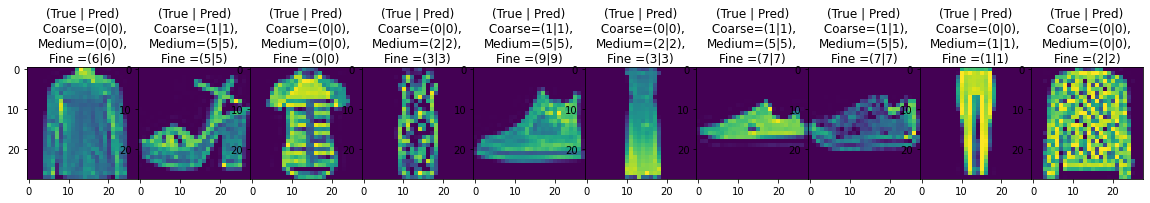

In [19]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix Level = 0 


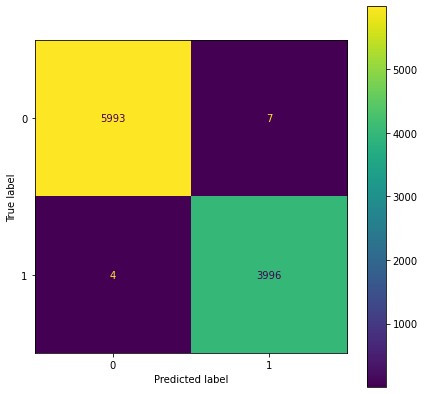


  • Classification Report for Level = 0 

              precision    recall  f1-score   support

           0    0.99933   0.99883   0.99908      6000
           1    0.99825   0.99900   0.99863      4000

    accuracy                        0.99890     10000
   macro avg    0.99879   0.99892   0.99885     10000
weighted avg    0.99890   0.99890   0.99890     10000

  • Confusion_Matrix Level = 1 


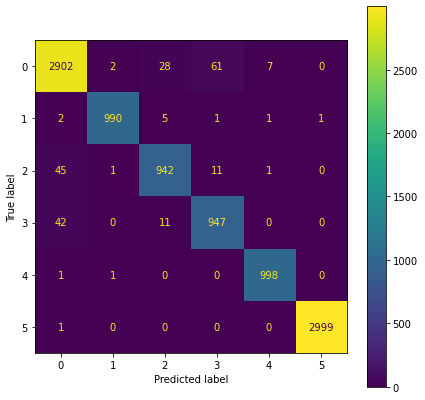


  • Classification Report for Level = 1 

              precision    recall  f1-score   support

           0    0.96960   0.96733   0.96846      3000
           1    0.99598   0.99000   0.99298      1000
           2    0.95538   0.94200   0.94864      1000
           3    0.92843   0.94700   0.93762      1000
           4    0.99106   0.99800   0.99452      1000
           5    0.99967   0.99967   0.99967      3000

    accuracy                        0.97780     10000
   macro avg    0.97335   0.97400   0.97365     10000
weighted avg    0.97786   0.97780   0.97782     10000

  • Confusion_Matrix Level = 2 


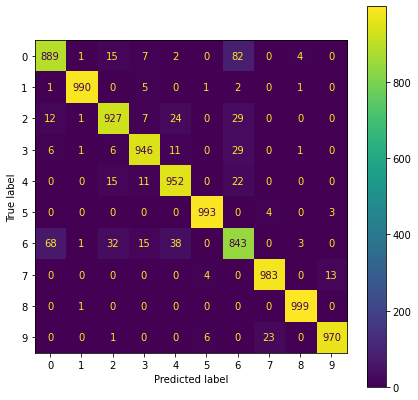


  • Classification Report for Level = 2 

              precision    recall  f1-score   support

           0    0.91086   0.88900   0.89980      1000
           1    0.99497   0.99000   0.99248      1000
           2    0.93072   0.92700   0.92886      1000
           3    0.95459   0.94600   0.95028      1000
           4    0.92697   0.95200   0.93932      1000
           5    0.98904   0.99300   0.99102      1000
           6    0.83714   0.84300   0.84006      1000
           7    0.97327   0.98300   0.97811      1000
           8    0.99107   0.99900   0.99502      1000
           9    0.98377   0.97000   0.97684      1000

    accuracy                        0.94920     10000
   macro avg    0.94924   0.94920   0.94918     10000
weighted avg    0.94924   0.94920   0.94918     10000



In [20]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label,directory)

In [21]:
h_measurements,consistency,exact_match, get_performance_report = metrics.hmeasurements(true_label, pred_label, dataset['tree'])

get_performance_report = {**{'Dataset': dataset['name'],
                             'Model': 'HD-CapsNet'},
                             **get_performance_report
                             } # merging two dictionaries (adding Dataset and Model name)
performance_metrics = pd.DataFrame(pd.DataFrame(get_performance_report.values(), get_performance_report.keys(), columns = ['Value']))
performance_metrics.to_csv(os.path.join(directory,'performance_metrics.csv'))
display(performance_metrics)

,Value
Dataset,FMNIST
Model,HD-CapsNet
Accuracy L_0,0.9989
Accuracy L_1,0.9778
Accuracy L_2,0.9492
HarmonicM_Accuracy_k1,0.974873
HarmonicM_Accuracy_k2,0.988323
HarmonicM_Accuracy_k5,0.99328
ArithmeticM_Accuracy_k1,0.9753
ArithmeticM_Accuracy_k2,0.988433
